In [195]:
#!XL
import tensorflow as tf
import IPython.display as display
import time
from tqdm import tqdm
import pandas as pd
from PIL import Image
from io import BytesIO
import requests

In [196]:
#!XL
import matplotlib.pyplot as plt
import numpy as np
import time

import warnings
warnings.filterwarnings("ignore")

In [197]:
#!XL
def clip_0_1(image):
    """
    Мы хотим уметь отображать нашу полученную картинку, а для этого ее значения должны 
    находится в промежутке от 0 до 1. Наш алгоритм оптимизации этого нигде не учитывает
    поэтому к полученному изображению мы будем применять "обрезку" по значению
    
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def load_img(path_to_img, max_dim=512):
    """
    Данная функция считывает изображение с диска и приводит его к такому размеру,
    чтобы бОльшая сторона была равна max_dim пикселей.

    Для считывания изображения воспользуемся функциями tensorflow.
    """
    img = tf.io.read_file(path_to_img) # считываени файла
    img = tf.image.decode_image(img, channels=3)  # декодинг
    img = tf.image.convert_image_dtype(img, tf.float32) # uint8 -> float32, 255 -> 1
    
    shape = img.numpy().shape[:-1]
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tuple((np.array(shape) * scale).astype(np.int32))

    img = tf.image.resize(img, new_shape) # изменение размера
    img = img[tf.newaxis, :] # добавляем batch dimension
    return img

def imshow(image, title=None):
    """
    Функция для отрисовки изображения
    """
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [24]:
#!XL
URL = 'https://api.ratengoods.com/api/v0.10/image/'

In [25]:
#!XL
data = pd.read_csv('data.csv')
data.key = data.key.astype(str)
data['links'] = URL + data.key
data.drop(columns=['Unnamed: 0'], inplace=True)
data = data.drop_duplicates(subset=['key'])
data.prod_id = data.prod_id.astype(int)
data

,key,name,source,prod_id,free_use,links
0,8732978,e214c0de5ab3134d7a8f918155af56826fe2872f.jpeg,USER,9489403,True,https://api.ratengoods.com/api/v0.10/image/873...
1,8722550,f010addceda8b3f61c2058023cba3aa3e4ff9842.jpeg,USER,2015371,True,https://api.ratengoods.com/api/v0.10/image/872...
2,8746670,0d378faeca33719cc5d2590a8ae0c018cd509885.jpeg,USER,8241001,True,https://api.ratengoods.com/api/v0.10/image/874...
3,8659332,a73d8495b5ccf2ce690690c3efad6739a8810b06.jpeg,USER,633711,True,https://api.ratengoods.com/api/v0.10/image/865...
4,8920811,36fa2a9a9dab9568ffc8de3a7c255ec0a6e8b28f.jpeg,USER,6633365,True,https://api.ratengoods.com/api/v0.10/image/892...
...,...,...,...,...,...,...
11971580,29641742,fe4c778094767ada41f9f0e030c72d4b08a7d6f5.jpeg,USER,30290197,True,https://api.ratengoods.com/api/v0.10/image/296...
11971592,342408,9b253544ef20fb4a18bc46861a74f001f21cb8e5.jpeg,USER,634376,True,https://api.ratengoods.com/api/v0.10/image/342408
11971594,403652,e4e9fde6e3005bd6daa9290389ce26cce1117d41.jpeg,USER,5959617,True,https://api.ratengoods.com/api/v0.10/image/403652
11971625,29641752,7075b4f9324e0f3521098958a8cdeef4bb70fe7e.jpeg,USER,29229119,True,https://api.ratengoods.com/api/v0.10/image/296...


In [26]:
#!XL
prod_ids = data.groupby(['prod_id']).size().reset_index(name='counts').sort_values(['counts'], ascending=False).prod_id.values[2:22]
prod_ids

array([2035578, 6092452,  885418, 6306467, 8103913, 8100001, 6420176,
       5783910,  240014, 8393179,  240099,  236751,  678969, 3155608,
       2340987,  511517, 2863813, 8575738, 2494432,  685331])

In [27]:
#!XL
data['kek'] = data.prod_id.apply(lambda x: x in prod_ids)
top20 = data[data.kek == True]
top20 = top20.reset_index().drop(columns=['index', 'kek'])
top20

,key,name,source,prod_id,free_use,links
0,8752976,90160a427196556ae074d85335bc40ce7710567a.jpeg,USER,3155608,True,https://api.ratengoods.com/api/v0.10/image/875...
1,8666831,a4595bc0bfd626e356a40287aad239dc1d3b2027.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/866...
2,2609661,0bc53ca0482f1d17eaf2d67ca97eff25ef0a7755.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
3,2609662,4fea65bfa661691b13fe265c6ede8f43d47118e0.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
4,2609663,5b3698dbaf7bc8b3e3e569fc5709fe79f7841c9f.jpeg,RNG,8103913,False,https://api.ratengoods.com/api/v0.10/image/260...
...,...,...,...,...,...,...
2607,29464798,263510b0bc49cfa0dc19d8c362d1ee94af9890c0.jpeg,admitad_utkonos,6306467,False,https://api.ratengoods.com/api/v0.10/image/294...
2608,29500502,b0aa2e292afcc5c3fd0dd50f96a77f9fc7db37a2.jpeg,USER,2340987,True,https://api.ratengoods.com/api/v0.10/image/295...
2609,29639414,bcbece4c3807c06b4241a8cf77de3ab2b37f97d1.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...
2610,29639406,8462d6a63d39daa727db26ff5cdf25b46743a139.jpeg,USER,6092452,True,https://api.ratengoods.com/api/v0.10/image/296...


(1.0, (1, 256, 192, 3))

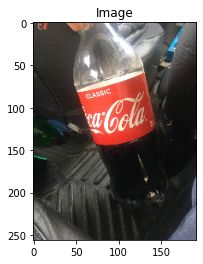

In [134]:
#!XL
url = top20[top20.prod_id == 6092452].links.values[1]
image_path = tf.keras.utils.get_file('Image11.jpg', url)

style_image = load_img(image_path, 256)
imshow(style_image, 'Image')
style_image.numpy().max(), style_image.numpy().shape

In [85]:
#!XL
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False
for layer in vgg.layers:
    print(layer.name)

input_13
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [35]:
#!XL
outputs = [vgg.get_layer('block3_conv2').output]
model = tf.keras.Model([vgg.input], outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [36]:
#!XL
def get_vgg_layers_model(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

get_vgg_layers_model(["block3_conv1"]).summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [39]:
#!XL
content_layers = ['block2_conv2']
extractor = FeatureExtractor(content_layers)
results = extractor(content_image)
print(results.keys())

dict_keys(['block2_conv2'])


In [40]:
#!XL
print(results["block2_conv2"].shape)

(128, 96, 128)


LOSS

In [190]:
#!XL
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [189]:
#!XL
class StyleExtractor:
    def __init__(self, layers):
        self.vgg_outputs_model =  get_vgg_layers_model(layers)
        self.vgg_outputs_model.trainable = False
        self.style_layers = layers

    def __call__(self, inputs):
        """
        На входе 4х мерный тензор (картинка). Значения пикселей ограничены 0..1!

        На выходе: {"имя слоя": матрица грамма выхода этого слоя}
        """
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs*255.) # VGG препроцессинг
        outputs = self.vgg_outputs_model(preprocessed_input)
        # посчитаем матрицу грамма для каждого выхода
        style_outputs = [gram_matrix(style_output)
                            for style_output in outputs]

        # добавим выходы в словарь, где ключ -- имя слоя, а значение -- его матрица грамма
        features_dict = {name:value for name, value in zip(self.style_layers, style_outputs)}

        return features_dict

In [216]:
#!XL
# выберем эти слои для сравнения матриц
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

extractor = StyleExtractor(style_layers)
style_targets = extractor(style_image)
for k, v in style_targets.items():
    print(f"{k}:{v.numpy().shape}")

block1_conv1:(1, 64, 64)
block2_conv1:(1, 128, 128)
block3_conv1:(1, 256, 256)
block4_conv1:(1, 512, 512)
block5_conv1:(1, 512, 512)


/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: extractor
  warnings.warn(message)


In [215]:
#!XL
# Переменная style_targets -- содержит словарь в котором сохранены матрицы грамма промежуточных выходов сети примененной к оригинальной картинке
extractor = StyleExtractor(style_layers)
style_targets = extractor(style_image)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: extractor
  warnings.warn(message)


In [191]:
#!XL
def loss(image): 
    """
    Получаем картинку, вычисляем признаки с помощью класса StyleExtractor. 
    Сравниваем их с style_targets с помощью MeanSquaredError.
    """
    current_features = extractor(image)
    loss = tf.add_n([tf.keras.losses.MeanSquaredError()(current_features[name], style_targets[name]) 
                                     for name in current_features.keys()])
    loss *= 1. / len(current_features)

    # для того чтобы результаты были больше похожи на настоящую картинку -- добавим регуляризацию
    # в реальных картинках цвета меняются плавно и нет цветового шума (шумные цветные пиксели поверх картинки)
    # при оптимизации мы часто будем получать такие результаты -- чтобы их уменьшать будуем штрафовать за такие резкие перепады цветов.
    # tota_variation -- нам в этом поможет
    loss += tf.image.total_variation(image)*1e4
    return loss

In [192]:
#!XL
def train_step(image, loss_func, optimizer):
    """
    Шаг оптимизации мы реализуем вручную (без .fit()). Такая реализация будет
    нам полезна в дальнейшем.

    """
    
    with tf.GradientTape() as tape: # "записываем" градиенты для дальнейшего использования
        loss = loss_func(image)
    grad = tape.gradient(loss, image) # dLoss/dImage
    optimizer.apply_gradients([(grad, image)]) # шаг градиентного спуск. в случае  GD: image = image - lambda*dLoss/dImage
                                         # картинка после этого шага изменилась!
    image.assign(clip_0_1(image)) # ~ image = clip_0_1(image), "обрезаем" неправильные значения
    return loss.numpy()

In [193]:
#!XL
def show_pair(original, generated, title=None):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    imshow(original, 'Original Image')
    plt.subplot(1, 2, 2)
    imshow(generated, title)

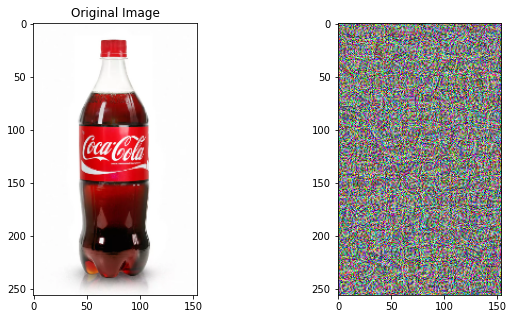

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: extractor
  warnings.warn(message)


In [217]:
#!XL
image = tf.Variable(np.random.rand(*style_image.numpy().shape).astype(np.float32))
opt = tf.keras.optimizers.Adam(learning_rate=0.08, beta_1=0.1, epsilon=1e-1)

# сделаем шаг оптимизации -- убедимся что все работает без ошибок.
train_step(image, loss_func=loss, optimizer=opt)
show_pair(style_image, image)

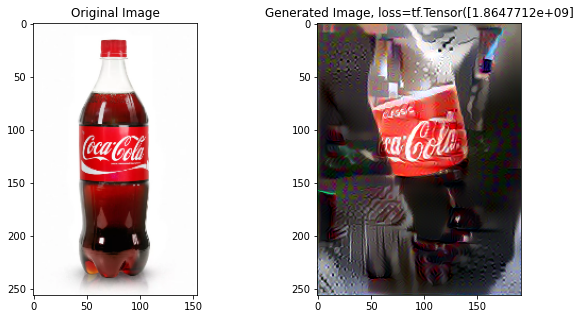

In [211]:
#!XL
image = tf.Variable(style_image1)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.01, epsilon=1e-1)

start = time.time()

epochs = 100
steps_per_epoch = 50

step = 0
for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
        step += 1
        train_step(image, loss_func=loss, optimizer=opt)

    display.clear_output(wait=True)
    show_pair(style_image, image, f"Generated Image.Train step: {step}, loss={str(loss(image)).split(',')[0]}")
    plt.savefig(f"results/result_{step:5d}.png", bbox_inches='tight')
    plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))
display.clear_output(wait=True)
show_pair(style_image, image, f"Generated Image, loss={str(loss(image)).split(',')[0]}")
plt.savefig(f"results/result.png", bbox_inches='tight')

(1.0, (1, 256, 192, 3))

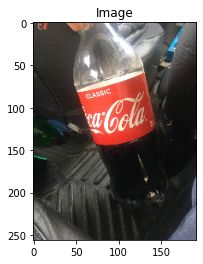

In [218]:
#!XL
url = top20[top20.prod_id == 6092452].links.values[1]
image_path1 = tf.keras.utils.get_file('Im1.jpg', url)

style_image1 = load_img(image_path1, 256)
imshow(style_image1, 'Image')
style_image1.numpy().max(), style_image1.numpy().shape

229376/225613 [==============================] - 0s 0us/step


(1.0, (1, 256, 154, 3))

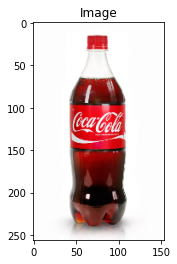

In [204]:
#!XL
url = top20[(top20.prod_id == 6092452) & (top20.source != 'USER')].links.values[0]
image_path = tf.keras.utils.get_file('Im222.jpg', url)

style_image = load_img(image_path, 256)
imshow(style_image, 'Image')
style_image.numpy().max(), style_image.numpy().shape

In [208]:
#!XL
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

extractor = StyleExtractor(style_layers)

style_targets1 = extractor(style_image1)

style_targets = extractor(style_image)

for k, v in style_targets1.items():
    print(f"{k}:{v.numpy().shape}")
    
for k, v in style_targets.items():
    print(f"{k}:{v.numpy().shape}")

block1_conv1:(1, 64, 64)
block2_conv1:(1, 128, 128)
block3_conv1:(1, 256, 256)
block4_conv1:(1, 512, 512)
block5_conv1:(1, 512, 512)
block1_conv1:(1, 64, 64)
block2_conv1:(1, 128, 128)
block3_conv1:(1, 256, 256)
block4_conv1:(1, 512, 512)
block5_conv1:(1, 512, 512)


In [177]:
#!XL
str(loss(style_image1)).split(',')[0]

'tf.Tensor([1.7594837e+10]'

(0.9824798, (1, 256, 191, 3))

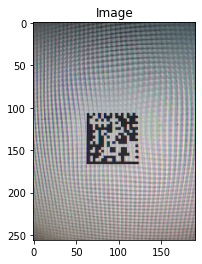

In [273]:
#!XL
url = top20.links.values[643]
image_path2 = tf.keras.utils.get_file('Im5.jpg', url)

style_image2 = load_img(image_path2, 256)
imshow(style_image2, 'Image')
style_image2.numpy().max(), style_image2.numpy().shape

In [213]:
#!XL
gram_matrix(style_image)

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[0.80177426, 0.7334828 , 0.73450655],
        [0.7334828 , 0.72109073, 0.72056997],
        [0.73450655, 0.72056997, 0.7205031 ]]], dtype=float32)>

block1_conv1:(1, 64, 64)
block2_conv1:(1, 128, 128)
block3_conv2:(1, 256, 256)
block4_conv2:(1, 512, 512)
block5_conv3:(1, 512, 512)
block5_conv4:(1, 512, 512)
{'block1_conv1': <tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[3.6512505e+03, 5.9048553e+02, 9.8795129e+02, ...,
         4.2026767e+02, 1.6597362e+03, 2.5500059e+03],
        [5.9048553e+02, 5.1102788e+03, 4.9042803e+03, ...,
         1.3355370e+00, 6.1206665e+02, 2.9784246e+03],
        [9.8795129e+02, 4.9042803e+03, 4.8097485e+03, ...,
         7.0026164e+00, 9.2274329e+02, 3.2663652e+03],
        ...,
        [4.2026767e+02, 1.3355370e+00, 7.0026164e+00, ...,
         5.8681211e+03, 3.0240457e+02, 2.5748370e+02],
        [1.6597362e+03, 6.1206665e+02, 9.2274329e+02, ...,
         3.0240457e+02, 2.0141865e+03, 2.3227554e+03],
        [2.5500059e+03, 2.9784246e+03, 3.2663652e+03, ...,
         2.5748370e+02, 2.3227554e+03, 4.0544443e+03]]], dtype=float32)>, 'block2_conv1': <tf.Tensor: shape=(1, 128, 128), dtype

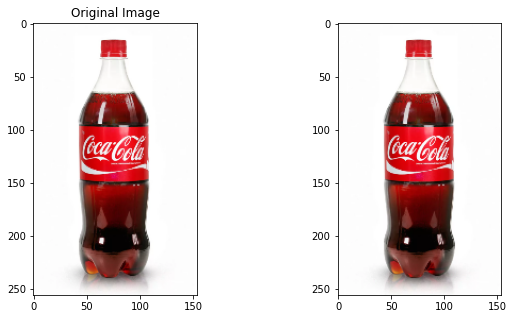

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: extractor
  warnings.warn(message)


In [243]:
#!XL
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv2', 
                'block4_conv2', 
                'block5_conv3',
                'block5_conv4']

extractor = StyleExtractor(style_layers)

style_targets = extractor(style_image)

for k, v in style_targets.items():
    print(f"{k}:{v.numpy().shape}")

print(style_targets)

show_pair(style_image, style_image)

In [238]:
#!XL
main_block = 'block5_conv4'

1001348.8


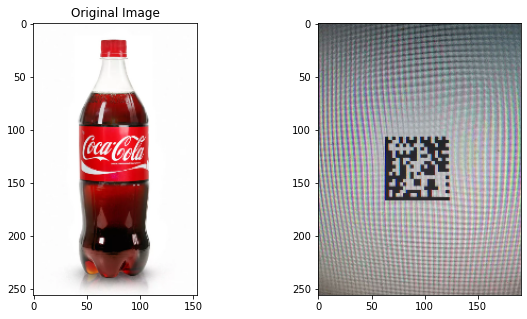

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:818: UserWarning: The following variables cannot be serialized: extractor
  warnings.warn(message)


In [274]:
#!XL
extractor = StyleExtractor([main_block, main_block])

style_targets1 = extractor(style_image1)
style_targets2 = extractor(style_image2)

print(abs((np.array(style_targets2['block5_conv4']) - np.array(style_targets['block5_conv4'])).sum()))

show_pair(style_image, style_image2)

In [ ]:
#!XL


In [ ]:
#!XL


In [15]:
#!XL


In [16]:
#!XL


In [17]:
#!XL


In [ ]:
#!XL
